In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
from collections import deque
plt.rcParams["figure.figsize"] = (10,10)

### Una entidad financiera está analizando cambiar uno de sus cajeros automáticos por uno con la funcionalidad de reciclador de billetes (si un cliente realiza un depósito de efectivo, ese efectivo estará disponible para que lo pueda retirar otro cliente).
### El cajero automático actual, que se quiere reemplazar, es de tipo estándar. No recicla los billetes, sino que posee dos compartimentos, uno con dinero para entregar y otro donde guarda el dinero que se deposita.
### Esto presenta los siguientes problemas:
###  -  Si no tiene más efectivo para entregar en el compartimento de retiro de dinero, no entrega efectivo aunque tenga en el compartimento de depósitos.
###  -  Si el compartimento que recibe los depósitos se completa, no puede recibir más.
### La entidad conoce que con el cajero actual el 20% de los clientes se retiraba sin poder extraer dinero, y sólo acepta cambiarlo si este porcentaje disminuye.
### Por simplicidad suponer que el cajero sólo expende billetes de 100 (pesos), tiene una capacidad máxima de 2000 billetes, y comienza el día con su carga completa.
### Si un cliente quiere extraer dinero y el cajero no cuenta con la suma suficiente, se va del mismo sin retirar nada. Algo similar ocurre cuando un cliente desea depositar efectivo y la capacidad máxima de billetes en el cajero fue alcanzada, retirándose sin poder depositar.
### En el relevamiento que realizó la entidad diferenció a sus clientes en dos grupos:
###  -  Grupo 1: Sólo retiran efectivo, y corresponden al 75% de los clientes que arriban. El tiempo que utilizan el cajero se puede modelar con una distribución exponencial de media 90 segundos. Cada cliente de este grupo, extrae una cantidad de billetes que sigue una distribución uniforme [3,50].
###  -  Grupo 2: Sólo realizan depósitos, son el 25% de los clientes totales. Utilizando el cajero un tiempo que siguen una distribución exponencial de media 5 minutos. Cada cliente de este grupo, deposita una cantidad de billetes que se puede modelar utilizando una distribución uniforme [10,110].
### Para determinar la frecuencia de arribos de clientes se han registrado 1000 tiempos entre arribos de los mismos.
### El área a cargo de modelar el problema, realizó dos propuestas para modelar este tiempo.
###  -  Utilizar una distribución de probabilidades Exponencial con media 𝜇 = 180 seg
###  -  Utilizar una distribución de probabilidades Exponencial con tasa 𝜆 = 1/240
### Se pide:
### a. Proponer un método para determinar la función de probabilidades a utilizar para modelar el tiempo entre arribos de clientes, y aplicarlo a los datos brindados en el archivo auxiliar al enunciado para determinar cuál de las distribuciones es más adecuada (utilizar nivel de significación = 1%).
### b. Utilizando (Python sin Simpy, Matlab u Octave) simular 1000 días completos de 24 hrs.
### c. Para un día en particular graficar la cantidad de billetes en el cajero luego de cada transacción.
### d. Calcular el tiempo medio que los clientes demoraron en el sistema (espera + utilización del cajero)
### e. ¿Recomienda a la entidad que implemente el cambio de cajero?


## ============================

## Solucion Propuesta:
### a. Para saber que modelo de los 2 dados es mas representativo de los datos que se tienen, dado que el tiempo es algo continuo podría ser optimo realizar un test de Kolmogorov Smirnov y ver cual de las dos distribuciones da un estadistico mas bajo.

In [4]:
tiempos = []
a='a'
datos = open("datosTP2EJ1.txt","r")
while (a != ''):
    a = datos.readline()
    if (a!= ''):
        tiempos.append(a)
datos.close()

In [5]:
for i in range(len(tiempos)):
    tiempos[i] = tiempos[i].replace(' \n','')
    tiempos[i] = float(tiempos[i])
tiempos = sorted(tiempos)

In [6]:
max_dif = 0
aux = 0
for i in range(len(tiempos)):
    aux = abs( ((i+1)/len(tiempos)) - (sc.stats.expon.cdf(tiempos[i], scale = 180)) )
    if ( aux > max_dif):
        max_dif = aux
max_dif

0.024730781065291363

In [7]:
sc.stats.kstest(tiempos,'expon',args=(0, 180)) # Parametros de la expon: loc (desplazamiento) y scale = 1/𝜆 

KstestResult(statistic=0.024730781065291363, pvalue=0.5735940033913054)

In [8]:
max_dif = 0
aux = 0
for i in range(len(tiempos)):
    aux = abs( ((i+1)/len(tiempos)) - (sc.stats.expon.cdf(tiempos[i], scale = 240)) )
    if ( aux > max_dif):
        max_dif = aux
max_dif

0.1157527363264863

In [9]:
sc.stats.kstest(tiempos,'expon',args=(0, 240)) # Parametros de la expon: loc (desplazamiento) y scale = 1/𝜆 

KstestResult(statistic=0.1157527363264863, pvalue=3.9547796943643075e-12)

## El estadistico es menor usando como media de la exponencial 1/𝜆 = 180 segundos, por lo tanto es la distribucion que vamos a usar.

## ===========================================

### b. Para realizar la simulacion de 1000 dias completos vamos a definir primero la simulacion de un dia cualquiera y luego por independencia entre dias vamos a simularlo 1000 veces. Hipotesis: Los cajeros se rellenan a las 00hs.

In [10]:
class Cajero(object):
    #Atributos
    billetes_extrac = 2000
    billetes_depos = 0
    capacidad = 2000
    billetes_luego_de_transacciones = []
    cola = deque([])
    
    #Recibe la cantidad de billetes que puede almacenar para extraer/depositar
    def __init__(self, capacidad):
        self.capacidad = capacidad
    
    #Devuelve la cantidad de billetes extraidos o -1 si no se pudo realizar la extraccion
    def extraer(self, n_billetes):
        billetes_extraidos = 0
        if (self.billetes_extrac - n_billetes < 0):
            if ((self.billetes_extrac + self.billetes_depos) - n_billetes < 0):
                return -1
            billetes_extraidos = self.billetes_extrac
            n_billetes -= billetes_extraidos
            billetes_extraidos += n_billetes
            self.billetes_extrac = 0
            self.billetes_depos -= n_billetes
        else:
            billetes_extraidos = n_billetes
            self.billetes_extrac -= n_billetes
        self.agregar_transaccion()
        return billetes_extraidos
    
    #Devuelve la cantidad de billetes depositados o -1 si no se pudo realizar el deposito
    def depositar(self, n_billetes):
        if (self.billetes_depos + n_billetes > self.capacidad):
            return -1
        else:
            self.billetes_depos += n_billetes
        self.agregar_transaccion()
        return n_billetes
    
    #Se rellenan los billetes para extracciones hasta la maxima capacidad y se vacian los billetes para deposito
    def reiniciar_capacidad(self):
        self.billetes_extrac = self.capacidad
        self.billetes_depos = 0
        self.billetes_luego_de_transacciones = []
    
    #Agrega la cantidad de billetes actuales en el cajero a la lista de billetes en el cajero luego de una transaccion
    def agregar_transaccion(self):
        self.billetes_luego_de_transacciones.append(self.billetes_extrac + self.billetes_depos)
        
    def obtener_transacciones(self):
        return self.billetes_luego_de_transacciones
    
    #Se agrega el tiempo que estara una persona usando el cajero
    def acolar(self, tiempo):
        self.cola.append(tiempo)
        
    #Devuelve el tiempo de la primer persona que ingreso a la cola y se lo remueve
    def desacolar(self):
        return self.cola.popleft()
    
    #Devuelve True si hay gente esperando para usar el cajero
    def tiene_cola(self):
        return (len(self.cola) > 0)
    
    #Devuelve el tiempo total sumado de la cola
    def obtener_tiempo_cola(self):
        tiempo = 0
        if (self.tiene_cola()):
            for i in self.cola:
                tiempo += i
        
        return tiempo
    
    #Hace que se reste el tiempo recibido a cada tiempo de las personas acoladas
    def transcurrir_tiempo(self, tiempo):
        if (self.tiene_cola()):
            temp = self.cola[0]
            while (self.tiene_cola() and tiempo > 0):
                self.cola[0] -= tiempo
                tiempo -= temp
                if (self.cola[0] <= 0):
                    self.desacolar()
                if (self.tiene_cola()):
                    temp = self.cola[0]
        

In [11]:
class Dia(object):
    #Atributos
    cajero = Cajero(1)
    arribos = deque([])
    tiempo_promedio_espera = 0
    clientes_insatisfechos = 0
    
    #Simula 24*60*60 segundos y asigna en los atributos los 
    def simular_dia(self, cajero, media_arribos, fraccion_extrac, media_extrac, media_depos):
        cajero.reiniciar_capacidad()
        self.arribos = deque([])
        tiempo_ultimo_arribo = 0
        self.clientes_insatisfechos = 0
        while (tiempo_ultimo_arribo < 24*60*60):
            tiempo_ultimo_arribo += sc.stats.expon.rvs(loc=0,scale=media_arribos)
            if (tiempo_ultimo_arribo < 24*60*60):
                self.arribos.append(tiempo_ultimo_arribo)
          
        tiempo_arribo_anterior = 0
        for t_arribo_actual in self.arribos:
            u = np.random.rand()
            if (u < fraccion_extrac):
                cajero.transcurrir_tiempo(t_arribo_actual - tiempo_arribo_anterior)
                cajero.acolar(sc.stats.expon.rvs(loc=0, scale=media_extrac))
                self.clientes_insatisfechos += (cajero.extraer(sc.stats.randint.rvs(low=3, high=50)) < 0)
            else:
                cajero.transcurrir_tiempo(t_arribo_actual - tiempo_arribo_anterior)
                cajero.acolar(sc.stats.expon.rvs(loc=0, scale=media_depos))
                self.clientes_insatisfechos += (cajero.depositar(sc.stats.randint.rvs(low=10, high=110)) < 0)
            tiempo_arribo_anterior = t_arribo_actual
            self.tiempo_promedio_espera += cajero.obtener_tiempo_cola()
    
        self.tiempo_promedio_espera /= len(self.arribos)
        cajero.transcurrir_tiempo(24*60*60 - tiempo_ultimo_arribo)
        self.cajero = cajero
        
    #Devuelve una lista con el tiempo de cada arribo de las personas durante un dia simulado
    def obtener_arribos(self):
        return self.arribos
    
    #Devuelve el tiempo promedio de espera para completar la operacion (incluyendo la cola) de las personas
    def obtener_tiempo_promedio_espera(self):
        return self.tiempo_promedio_espera
    
    #Devuelve la cantidad de clientes que vinieron durante un dia simulado y no pudieron realizar la operacion
    def obtener_clientes_insatisfechos(self):
        return self.clientes_insatisfechos
    
    #Devuelve la cantidad de clientes que vinieron durante el lapso de un dia simulado
    def obtener_cantidad_clientes(self):
        return len(self.arribos)
    
    

In [12]:
#Simulacion de 1000 dias:
clientes_totales = 0
clientes_insatisfechos_totales = 0

#Inicializo un cajero con capacidad de 2000 billetes
cajero = Cajero(2000)

#Inicializo un objeto dia
dia = Dia()

#Simulo 1000 dias (Consideracion: El cajero conserva la cola del dia anterior)
for i in range(1000):
    dia.simular_dia(cajero, media_arribos = 180, fraccion_extrac = 0.75, media_extrac = 90, media_depos = 5*60)
    clientes_totales += dia.obtener_cantidad_clientes()
    clientes_insatisfechos_totales += dia.obtener_clientes_insatisfechos()
    
#Si quedo gente esperando en el cajero luego de los 1000 dias los marco como insatisfechos
while(cajero.tiene_cola()):
    clientes_totales += 1
    cajero.desacolar()

In [13]:
print("Clientes totales: " + str(clientes_totales))
print("Clientes insatisfechos totales: " + str(clientes_insatisfechos_totales))

Clientes totales: 481148
Clientes insatisfechos totales: 21210


## Punto e: Obtengo la cantidad de clientes que no pudieron realizar la transaccion y la divido por la cantidad de clientes en total que vinieron al cajero, si la cantidad es inferior a 0.2 entonces conviene cambiar el cajero anterior por este nuevo

In [14]:
clientes_insatisfechos_totales/clientes_totales

0.0440820703816705

## Punto c: Grafica de billetes en el cajero luego de transacciones en un dia

In [15]:
otro_cajero = Cajero(2000)
otro_dia = Dia()
otro_dia.simular_dia(otro_cajero, media_arribos = 180, fraccion_extrac = 0.75, media_extrac = 90, media_depos = 5*60)
transacciones = []
transacciones = otro_cajero.obtener_transacciones()

while(len(otro_dia.obtener_arribos()) != len(transacciones)):
    otro_dia.obtener_arribos().pop()

arribos_h = otro_dia.obtener_arribos()
for i in range(len(arribos_h)):
    arribos_h[i] = arribos_h[i] / (60*60)

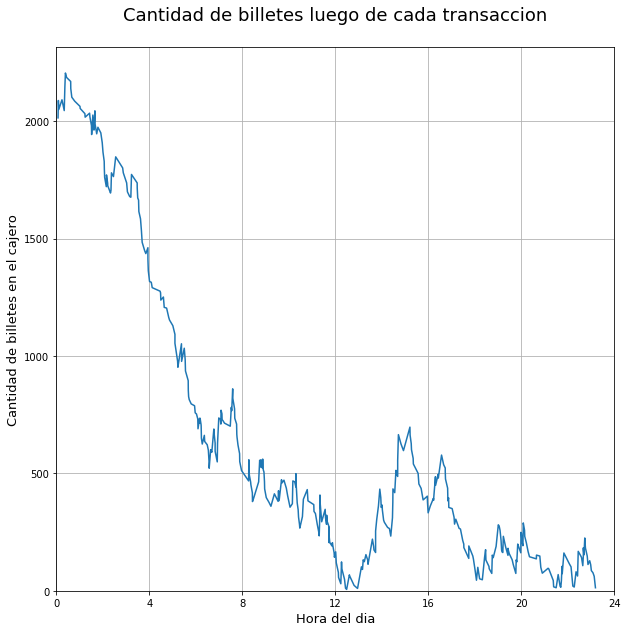

In [16]:
sns.lineplot(arribos_h, transacciones)
plt.grid()
plt.title('Cantidad de billetes luego de cada transaccion\n', fontsize=18)
plt.xlim(left=0,right=24)
plt.ylim(bottom=0)
plt.xticks(range(0,25,4))
plt.xlabel('Hora del dia', fontsize=13)
plt.ylabel('Cantidad de billetes en el cajero', fontsize=13);

## Punto d: Tiempo medio de espera de los clientes en un dia particular

In [17]:
print("En promedio los clientes esperan: " + str(otro_dia.obtener_tiempo_promedio_espera() / 60) + " minutos")

En promedio los clientes esperan: 7.7696059521615615 minutos
